In [ ]:
import AdaIN
import matplotlib.pyplot as plt
import importlib
importlib.reload(AdaIN)

In [ ]:
import construct_input_data
import os
dataDir = 'input/content/'
dataPickle = "input/data.pickle"
if os.path.isfile(dataPickle):
    print('%s exists' %dataPickle)
else:
    construct_input_data.freeze_image_data(dataDir,dataPickle)
input_data = construct_input_data.load_image_data(dataPickle)

In [ ]:
import torch_net_param
import os
vgg_t7_file = 'models/vgg_normalised.t7'
gt_param_file = 'models/param-0.pickle'
if os.path.isfile(gt_param_file):
    print('%s exists' %gt_param_file)
else:
    torch_net_param.extract_net_param_from_t7(vgg_t7_file,gt_param_file)  

In [ ]:
import get_x_w_y
from lib.decompose import dictionary
importlib.reload(get_x_w_y)
modified_param_file = 'models/param-1.pickle'
top_name = "Conv2D_3"
bottom_name = "Conv2D_2"

feats_Y, points_dict,W,conv_map = get_x_w_y.get_gtY(gt_param_file,input_data,top_name)
feats_X = get_x_w_y.get_X(modified_param_file,input_data,top_name,points_dict)

print(conv_map)

feats_W = W.transpose((3,2,0,1)) #(n,c,h,w)
feats_X = feats_X.transpose((0,3,1,2)) #(N,c,h,w)

output = dictionary(feats_X,feats_W,feats_Y,rank = int(feats_W.shape[1]/2))



In [ ]:
idx = output[0]
newW = output[1].transpose(2,3,1,0)
newB = output[2]
import torch_net_param
net_param = torch_net_param.load_net_param(modified_param_file)
top_idx = conv_map[top_name]
bottom_idx = conv_map[bottom_name]
print("top_idx,bootom_idx:",top_idx,bottom_idx)

print("bottom size:")
bottom_val = net_param[bottom_idx]['conv']
print(bottom_val[0].shape)
bottom_val[0] = bottom_val[0][...,idx]
print(bottom_val[0].shape)
bottom_val[2] = bottom_val[2][idx]
print(bottom_val[2].shape)

print("top size:") 
top_val = net_param[top_idx]['conv']
print(top_val[0].shape)
print(top_val[2].shape)
top_val[0] = newW
top_val[2] = top_val[2] + newB
print(top_val[0].shape)
print(top_val[2].shape)

outfile = "models/param-2.pickle"
torch_net_param.freeze_net_param(net_param,outfile)

#test
net_param = torch_net_param.load_net_param(outfile)
top_idx = conv_map[top_name]
print(net_param[top_idx]['conv'][0].shape)


(1, 474, 712, 3)
(1, 474, 712, 3)
Tensor("input_content:0", shape=(1, ?, ?, ?), dtype=float32)
Tensor("input_style:0", shape=(1, ?, ?, ?), dtype=float32)
load...
load...
load...


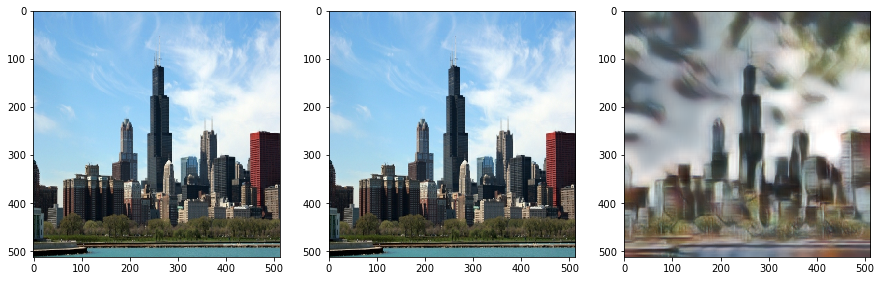

(1, 474, 712, 3)
(1, 795, 1000, 3)
Tensor("input_content:0", shape=(1, ?, ?, ?), dtype=float32)
Tensor("input_style:0", shape=(1, ?, ?, ?), dtype=float32)
load...
load...
load...


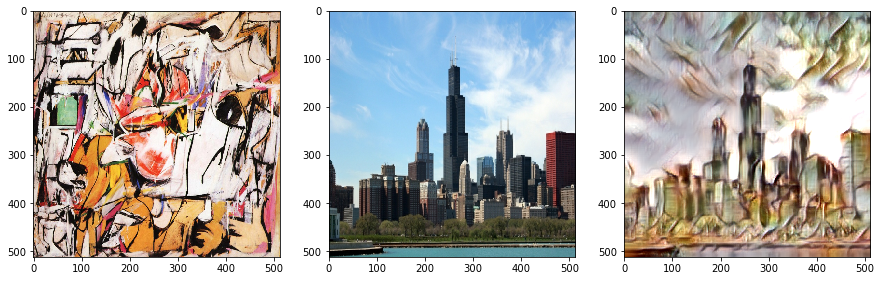

(1, 1050, 1680, 3)
(1, 401, 570, 3)
Tensor("input_content:0", shape=(1, ?, ?, ?), dtype=float32)
Tensor("input_style:0", shape=(1, ?, ?, ?), dtype=float32)
load...
load...
load...


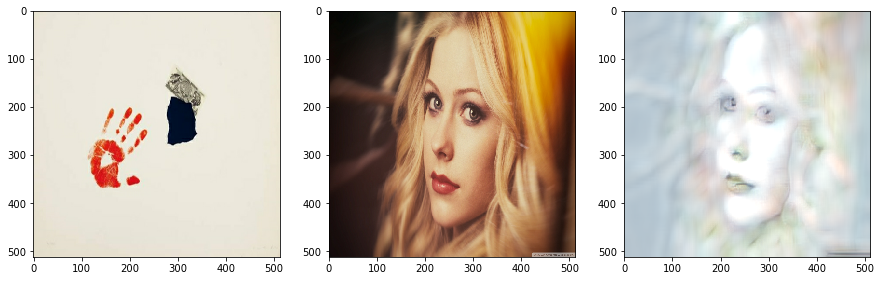

(1, 512, 729, 3)
(1, 800, 591, 3)
Tensor("input_content:0", shape=(1, ?, ?, ?), dtype=float32)
Tensor("input_style:0", shape=(1, ?, ?, ?), dtype=float32)
load...
load...
load...


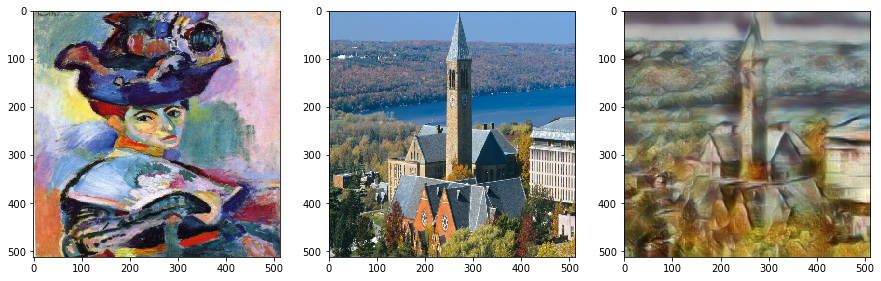

(1, 640, 640, 3)
(1, 605, 727, 3)
Tensor("input_content:0", shape=(1, ?, ?, ?), dtype=float32)
Tensor("input_style:0", shape=(1, ?, ?, ?), dtype=float32)
load...
load...
load...


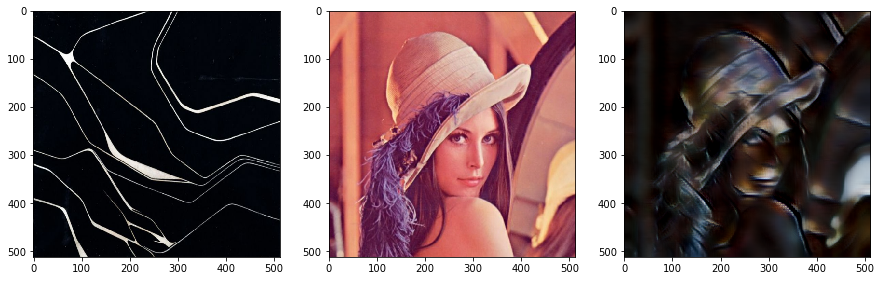

(1, 512, 512, 3)
(1, 300, 300, 3)
Tensor("input_content:0", shape=(1, ?, ?, ?), dtype=float32)
Tensor("input_style:0", shape=(1, ?, ?, ?), dtype=float32)
load...
load...
load...


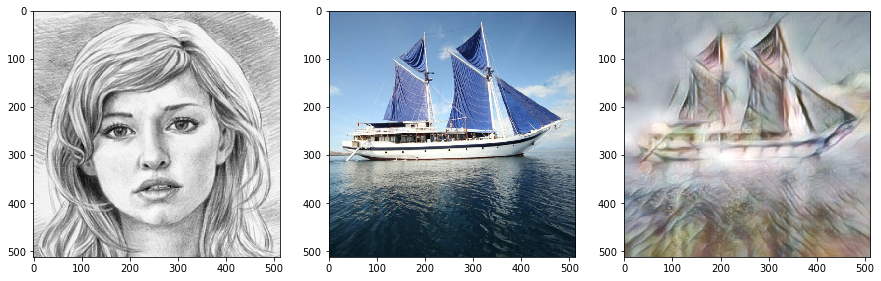

(1, 564, 564, 3)
(1, 517, 512, 3)
Tensor("input_content:0", shape=(1, ?, ?, ?), dtype=float32)
Tensor("input_style:0", shape=(1, ?, ?, ?), dtype=float32)
load...
load...
load...


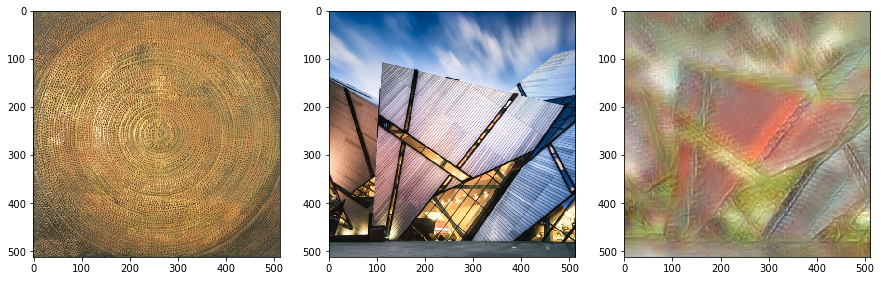

In [1]:
import torch_net_param
import tensorflow as tf
import AdaIN
import matplotlib.pyplot as plt
import importlib
importlib.reload(AdaIN)

#测试
def stylize2(content, style, alpha, vgg_t7_file, decode_t7_file, resize=[512,512]):
    c_image = None
    s_image = None
    with tf.Session() as sess:
        image = tf.image.decode_jpeg(tf.read_file(content))
        image = tf.expand_dims(image,0)
        image = tf.cast(image,tf.float32)
        c_image = sess.run(image)
        print(c_image.shape)
        image = tf.image.decode_jpeg(tf.read_file(style))
        image = tf.expand_dims(image,0)
        image = tf.cast(image,tf.float32)
        s_image = sess.run(image)
        print(s_image.shape)
   
    with tf.Graph().as_default() as g, tf.Session(graph=g) as sess, tf.variable_scope(tf.get_variable_scope(), reuse=False) as scope:
        c_holder = tf.placeholder(tf.float32,[1,None,None,None],name="input_content")
        s_holder = tf.placeholder(tf.float32,[1,None,None,None],name="input_style")
        print(c_holder)
        print(s_holder)
        
        c = tf.reverse(c_holder, axis=[-1]) / 255.0
        s = tf.reverse(s_holder, axis=[-1]) / 255.0
        
        if resize is None:
            resize = [512,512]
            
        c = tf.image.resize_images(c, resize)
        s = tf.image.resize_images(s, resize)
        
        
        c_vgg,_ = torch_net_param.construct_net(c, g, vgg_t7_file)
        s_vgg,_ = torch_net_param.construct_net(s, g, vgg_t7_file)
 
        stylized_content = AdaIN.AdaIN(c_vgg, s_vgg, alpha)
        
        
        #c_decoded, _ = AdaIN.graph_from_t7(stylized_content, g, decode_t7_file)        
        c_decoded, _ = torch_net_param.construct_net(stylized_content, g, decode_t7_file) 
        c_decoded = tf.reverse(c_decoded,axis=[-1])*255.0
        c = tf.reverse(c,axis=[-1])*255.0
        s = tf.reverse(s,axis=[-1])*255.0
        
        # 服务器输出
        test_out = tf.reshape(c_decoded,resize + [3])
       
        # 手机上输出
        output = tf.clip_by_value(c_decoded,0,255)
        output = tf.reshape(output,[-1],name="output")
        
        c = tf.reshape(c,resize + [3])
        s = tf.reshape(s,resize + [3])
        tf.train.write_graph(sess.graph_def, "", "model1.pb", False)
        feed_dict = {c_holder:c_image,s_holder:s_image}
        combined, style_image, content_image = sess.run([test_out, s, c], feed_dict=feed_dict)
        return combined, style_image, content_image
    
content_style_pairs = [ ['input/content/chicago.jpg', 'input/content/chicago.jpg'],
                        ['input/content/chicago.jpg', 'input/style/asheville.jpg'],
                        ['input/content/avril.jpg', 'input/style/impronte_d_artista.jpg'],
                        ['input/content/cornell.jpg', 'input/style/woman_with_hat_matisse.jpg'],
                        ['input/content/lenna.jpg', 'input/style/en_campo_gris.jpg'],
                        ['input/content/sailboat.jpg', 'input/style/sketch.png'],
                        ['input/content/modern.jpg', 'input/style/goeritz.jpg'],                   
                      ]
#content_style_pairs = [ ['input/content/chicago.jpg', 'input/content/chicago.jpg'],]
#decoder_t7 = 'models/decoder.t7'
decoder_t7 = 'models/decoder-param-0.pickle.Conv2D_1.Conv2D.Conv2D_2.Conv2D_1.Conv2D_3.Conv2D_2.Conv2D_4.Conv2D_3.Conv2D_5.Conv2D_4.Conv2D_6.Conv2D_5.Conv2D_7.Conv2D_6.Conv2D_8.Conv2D_7'
vgg_t7 = 'models/param-0.pickle.Conv2D_2.Conv2D_1.Conv2D_3.Conv2D_2.Conv2D_4.Conv2D_3.Conv2D_5.Conv2D_4.Conv2D_6.Conv2D_5.Conv2D_7.Conv2D_6.Conv2D_8.Conv2D_7.Conv2D_9.Conv2D_8'
#vgg_t7 = 'models/param-0.pickle'
for content, style in content_style_pairs:
    alpha = 1
    stylized, content_image, style_image = stylize2(content, style, alpha, vgg_t7, decoder_t7, resize=[512,512])
    fig = plt.figure(figsize=(15,30))
    a=fig.add_subplot(1,3,1)
    plt.imshow(AdaIN.any_to_uint8_clip(content_image))
    a=fig.add_subplot(1,3,2)
    plt.imshow(AdaIN.any_to_uint8_clip(style_image))
    a=fig.add_subplot(1,3,3)
    plt.imshow(AdaIN.any_to_uint8_clip(stylized))
    plt.show()

In [ ]:
conv_dict = {'Conv2D': 0, 'Conv2D_1': 2, 'Conv2D_2': 5, 'Conv2D_3': 9, 'Conv2D_4': 12, 'Conv2D_5': 16, 'Conv2D_6': 19, 'Conv2D_7': 22, 'Conv2D_8': 25, 'Conv2D_9': 29}

conv_layer = sorted(conv_dict.keys())[1:]
top_bottom_pair_list = zip(conv_layer[1:],conv_layer[:-1])
for top_bottom in top_bottom_pair_list:
    top_name,bottom_name = top_bottom
    print(top_name,bottom_name)

In [ ]:
cidx = np.array(16*[False] + (W_shape[2]-16)*[True])
print(cidx)
new_chanel_num = sum(cidx)
print(new_chanel_num)

In [ ]:
import AdaIN
import matplotlib.pyplot as plt
import importlib
import pickle
import torch_net_param
import numpy as np
import tensorflow as tf
importlib.reload(AdaIN)

vgg_t7_file = 'nodels/vgg_normalised.t7'
param_file = 'models/param-0.pickle.Conv2D_2.Conv2D_1.Conv2D_3.Conv2D_2.Conv2D_4.Conv2D_3.Conv2D_5.Conv2D_4.Conv2D_6.Conv2D_5.Conv2D_7.Conv2D_6.Conv2D_8.Conv2D_7.Conv2D_9.Conv2D_8'
param_file = 'models/param-0.pickle'
#net_param = torch_net_param.extract_net_param_from_t7(vgg_t7_file,param_file)
resize = [512,512]
#test
with tf.Graph().as_default() as g, tf.Session(graph=g) as sess, tf.variable_scope(tf.get_variable_scope(), reuse=False) as scope:
    c, c_filename = AdaIN.image_from_file(g, 'content_image', size=resize)
    c = torch_net_param.construct_net(c,g,param_file)
    for i in g.get_operations():
        if i.name.endswith("filter"):
            Y_tensor = g.get_tensor_by_name(i.name + ":0")
            print(Y_tensor)
            Y = sess.run(Y_tensor)
            Y_max,Y_min = np.max(Y),np.min(Y)
            print("max,min",Y_max,Y_min)
    

In [ ]:
import numpy as np
import tensorflow as tf
a = np.arange(12).reshape(2,1,6)
print(a)
#b = tf.constant(a)
c = tf.squeeze(a,1)
with tf.Session() as sess:
    res = sess.run(c)
    print(res)

In [ ]:
import AdaIN
import matplotlib.pyplot as plt
import importlib
importlib.reload(AdaIN)
import construct_input_data
import os
import get_x_w_y
from lib.decompose import dictionary
import torch_net_param
importlib.reload(get_x_w_y)

dataDir = '/data/mydata/val/ilsvrc2012_val'
dataPickle = "input/image_val_data.pickle"
if os.path.isfile(dataPickle):
    print('%s exists' %dataPickle)
else:
    construct_input_data.freeze_image_data(dataDir,dataPickle)
input_data = construct_input_data.load_image_data(dataPickle)

In [ ]:
#进一步计算decoder的输入，即AdaIN的输出.
def get_AdaIN_input(input_data, alpha, vgg_t7_file,resize =[512,512]):
    input_shape = input_data.shape
    nPicsPerBatch = input_shape[1]
    nBatches = input_shape[0]
    nPics = nPicsPerBatch * nBatches
    with tf.Graph().as_default() as g, tf.Session(graph=g) as sess, tf.variable_scope(tf.get_variable_scope(), reuse=False) as scope:
        c_holder = tf.placeholder(tf.float32,[1,None,None,None],name="input_content")
        s_holder = tf.placeholder(tf.float32,[1,None,None,None],name="input_style")
        print(c_holder)
        print(s_holder)
        
        '''
        c = tf.reverse(c_holder, axis=[-1]) / 255.0
        s = tf.reverse(s_holder, axis=[-1]) / 255.0
        
        if resize is None:
            resize = [512,512]
            
        c = tf.image.resize_images(c, resize)
        s = tf.image.resize_images(s, resize)
        '''
        
        c_vgg,_ = torch_net_param.construct_net(c_holder, g, vgg_t7_file)
        s_vgg,_ = torch_net_param.construct_net(s_holder, g, vgg_t7_file)
 
        stylized_content = AdaIN.AdaIN(c_vgg, s_vgg, alpha)
        print("sc_shape:",stylized_content.shape)
        output_data = None
       
        for i in range(nPics):
            print("i:",i)
            batch_idx = np.random.randint(nBatches,size=(2,))
            pics_idx = np.random.randint(nPicsPerBatch,size=(2,))
            c = np.expand_dims(input_data[batch_idx[0]][pics_idx[0]],axis=0)
            s = np.expand_dims(input_data[batch_idx[1]][pics_idx[1]],axis=0)
            print("c.shape:",c.shape)
            print("s.shape:",s.shape)
            res = sess.run(stylized_content,feed_dict={c_holder:c,s_holder:s})
            print("res.shape:",res.shape)       
            a,b = divmod(i,nPicsPerBatch)
            if not output_data:
                output_shape = [nBatches,nPicsPerBatch] + list(res.shape[1:])
                output_data = np.ndarray(shape=output_shape)
            output_data[a][b] = np.squeeze(res, axis=0)
            break
        return output_data
vgg_t7 = 'models/param-0.pickle'
decoder_input_data = get_AdaIN_input(input_data, alpha, vgg_t7)

In [ ]:
print(decoder_input_data.shape)
print(decoder_input_data[0,0,0,0])